Emulating the [DFG benchmark 2D-2, Re=100](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html)

"This benchmark simulates the time-periodic behaviour of a fluid in a pipe with a circular obstacle. It is set up in 2D with geometry data similar to the Re=20 case."

Using a single PINN (no domain decomposition)

This notebook contains code for initializing the XPINN, explaining the problem specifications from [DFG benchmark 2D-2, Re=100](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html), setting up the network architecture, defining the pde residual functions, specifying the boundary conditions and training the network


In [1]:
from xpinn import XPINN
import optax
from jax import hessian, jit, vmap, grad
import jax.numpy as np
import json


#### Initalizing the XPINN

In this expereiment we'll only deal with a single pinn for the entire domain

In [3]:
from utils import data_path

data_path = data_path / "NavierStokes"

file = data_path / "single_pinn_train_w_temporal.json"
file_test = data_path / "test_w_temporal.json"
activation = np.tanh
xpinn = XPINN(file, activation)

Same decomposition as the laminar case

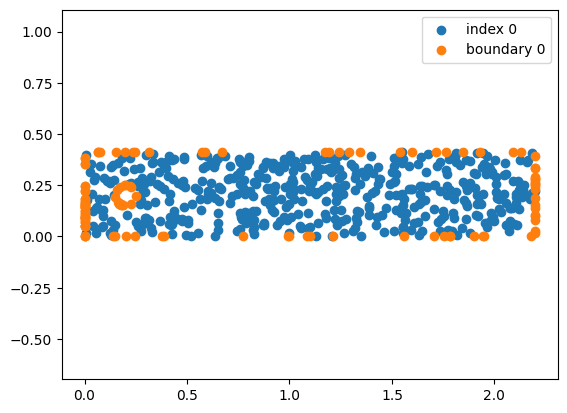

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.axis("equal"
)
for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

# Problem specifications

The problem specifications are only a slight modification from the laminar (Re=20) case.
Firstly there is a added time derivative to the navier stokes. In the [DFG benchmark 2D-2, Re=100](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html) notation

$$
\mathbf{u_t} -\nu \nabla^2 \mathbf{u} + (\mathbf{u} \cdot \nabla)\mathbf{u} + \nabla p = \mathbf{0}, \hspace{3mm} \nabla \cdot \mathbf{u} = 0
$$
$\nu = 0.001$.
In our notation, which isolates the x- and y-flow as $u$ and $v$, the PDE expressions for the second-order spatial derivatives can be written as:

$$f = u_t -\nu (u_{xx} + u_{yy}) + u u_x + v u_y + p_x = 0,$$

$$g = v_t -\nu (v_{xx} + v_{yy}) + u v_x + v v_y + p_y = 0$$

Our zero divergence from incompressibility:

$$ u_x + v_y = 0$$


Now our problem is dependent on time so our network is now a function from 3D to 2D space

$$\mathcal{N}_{\theta}:\mathbb{R}^3 \to \mathbb{R}^2, \hspace{4mm}(x,y,t) \to (\psi, p)$$

Then $u$ and $v$ is given by

The last change from our laminar case is a change on the value of $U$ in the inflow function. In the laminar case $U = 0.3$ now $U = 1.5$. We thus have a stronger inflow

In [6]:
U = 1.5
inflow_func = lambda y: 4 * U * y * (0.41 - y)/0.41**2


In [4]:
from typing import Callable
from type_util import Params, Array
from base_network import neural_network

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))


#### Derivatives of $\psi$

In [5]:
psi_func = lambda params, xyt: model(params, xyt)[0]

hess_psi = hessian(psi_func, argnums=1)
d_psi_dxyt = grad(psi_func, argnums=1)

u_x = lambda params, xyt: hess_psi(params, xyt)[0,1] #psi_yx
u_y = lambda params, xyt: hess_psi(params, xyt)[1,1] #psi_yy
u_xx = lambda params, xyt: grad(u_x, argnums=1)(params, xyt)[0] #psi_yxx
u_t = lambda params, xyt: hess_psi(params, xyt)[1,2] #psi_ty
u_yy = lambda params, xyt: grad(u_y, argnums=1)(params, xyt)[1] #psi_yyy

v_y = lambda params, xyt: -hess_psi(params, xyt)[0,1] #-psi_yx
v_x = lambda params, xyt: -hess_psi(params, xyt)[0,0] #-psi_xx
v_t = lambda params, xyt: -hess_psi(params, xyt)[1,2] #-psi_ty
v_xx = lambda params, xyt: grad(v_x, argnums=1)(params, xyt)[0] #-psi_xxx
v_yy = lambda params, xyt: grad(v_y, argnums=1)(params, xyt)[1] #-psi_yyy


u = lambda params, xyt: d_psi_dxyt(params, xyt)[1]
v = lambda params, xyt: -d_psi_dxyt(params, xyt)[0]

#### Derivatives of p

In [6]:
p = lambda params, xyt: model(params, xyt)[1]

p_x = lambda params, xyt: grad(p, argnums=1)(params, xyt)[0]
p_y = lambda params, xyt: grad(p, argnums=1)(params, xyt)[1]

#### Residual functions f and g

In [11]:
def navier_stokes_residual_factory(index: int, nu: float) -> Callable[[Params, dict[str, Array]], Array]:
                                                   
    def f(params, xyt):
        return (u_t(params, xyt) + u(params, xyt)*u_x(params, xyt) + 
                v(params, xyt)*u_y(params, xyt) + p_x(params, xyt) - 
                nu*(u_xx(params, xyt) + u_yy(params, xyt)))
    def g(params, xyt):
        return (v_t(params, xyt) + u(params, xyt)*v_x(params, xyt) + 
                v(params, xyt)*v_y(params, xyt) + p_y(params, xyt) - 
                nu*(v_xx(params, xyt) + v_yy(params, xyt)))
        
    def residual(params, xyt):
        return f(params, xyt)**2 + g(params, xyt)**2
    
    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual
    
    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return np.mean(v_residual(params, pts))
    
    return interior_loss

In [11]:
def boundary_loss_factory(inflow_func: Callable[[Array], Array], nu:float) -> Callable[[Params, dict[str, Array]], Array]:
    
    def left_boundary_loss(params, xyt):
        return (u(params, xyt) - inflow_func(xyt[1]))**2 + v(params, xyt)**2
    
    def wall_boundary_loss(params, xyt):
        return u(params, xyt)**2 + v(params, xyt)**2
        
    def right_boundary_loss(params, xyt):
        return nu*u_x(params, xyt)**2 + nu*u_y(params, xyt)**2
    
    v_left_boundary_loss = vmap(left_boundary_loss, (None, 0))
    v_wall_boundary_loss = vmap(wall_boundary_loss, (None, 0))
    v_right_boundary_loss = vmap(right_boundary_loss, (None, 0))
    
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:
        
        left_pts = points['left boundary']
        right_pts = points['right boundary']
        wall_pts = points['wall boundary']
        left = v_left_boundary_loss(params, left_pts)
        right = v_right_boundary_loss(params, right_pts)
        wall = v_wall_boundary_loss(params, wall_pts)
    
        all = np.concatenate((left,  wall, right))
     
        return np.mean(all)
    
    return boundary_loss
    

NameError: name 'Callable' is not defined

In [12]:
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory(inflow_func, nu=0.01)
p0.interior_loss = navier_stokes_residual_factory(0, nu=0.01)
p0.create_loss()


<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x000001987A55FB50>>

In [10]:
shape = [3, 20, 20, 20, 2]
exponential_decay = optax.exponential_decay(
    init_value=0.001,
    transition_steps=10000,
    transition_begin=15000,
    decay_rate=0.1,
    end_value=0.0000001,
)
optimizer = optax.adam(learning_rate=exponential_decay)

xpinn.PINNs[0].init_params(shape, optimizer)

In [8]:
n_iter = 1000
losses = xpinn.run_iters(n_iter)

AttributeError: 'PINN' object has no attribute 'params'